In [1]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") 
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Soft_Com/Assignment_3/Dataset_2.csv',encoding='latin1')
df = df.sample(frac=1).reset_index(drop=True)
df.sample(10)

,text,polarity
5836,Happy Gilmore is on,0
1705,me pretending depression isnt constantly smoth...,1
5067,yeaj! ... nu hat mein macbook auch applecare p...,0
898,@itsprincess why not? Does it taste bad? LOL p...,0
4466,i will never get over the fact how easy it is ...,1
7334,http://www.blogtv.com/People/e-dub Learn sign ...,0
5206,I hope you get put away I hope you fuckin die ...,0
3029,Long weekend here in Canada! Heading over the ...,0
6744,grass: greensun: shininglowest test score: dro...,1
4905,And with that im going to sleep...HAVE FUN FOL...,0


In [4]:
df.groupby('polarity').size()

polarity
0    8000
1    2314
dtype: int64

Text(0.5, 0, 'text')

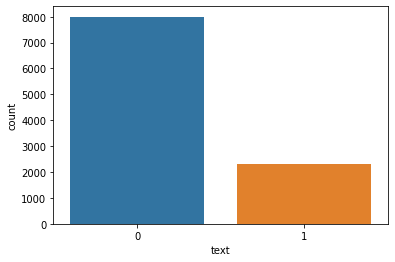

In [5]:

sns.countplot(df.polarity)
plt.xlabel('text')

In [6]:
class Sequences(Dataset):
    def __init__(self, data):
        self.vectorizer = CountVectorizer(stop_words='english')
        self.sequences = self.vectorizer.fit_transform(data.text.tolist())
        self.labels = data.polarity.tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
    
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]

In [7]:
batch_size = 100

In [8]:
dataset = Sequences(df)
train_size = int(len(dataset)*.8);
test_size = int(len(dataset) - train_size);
train_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
len(dataset.token2idx)

22212

In [10]:
input_size = len(dataset.token2idx)
hidden_size = 128
num_classes = 2
num_layers = 4
learning_rate = 0.01
sequence_length = 1
num_epochs = 40
batch_size = 100

In [11]:
print(len(train_dataset))
print(len(test_dataset))

8251
2063


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [13]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.D = 2
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh',bidirectional=True)
        self.fc = nn.Linear(self.D*hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.D*self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # Forward propagate LSTM
        out, _ = self.rnn(x, h0) 
        h0 = torch.zeros(self.D*self.num_layers, out.size(0), self.hidden_size).to(device) 
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [14]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [16]:
# Train the model
y_pred = []
y_test = []
iter = []
losses = []
itr = 0
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (tweets, labels) in enumerate(train_loader):
        tweets = tweets.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        tweets = torch.tensor(tweets, dtype = torch.float)
        # Forward pass
        outputs = model(tweets)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        itr = itr + 1
        if (i+1) % 10 == 0:
            iter.append(itr)
            losses.append(loss.item())
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for tweets, labels in test_loader:
        tweets = tweets.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        tweets = torch.tensor(tweets, dtype = torch.float)
        outputs = model(tweets)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_pred.extend(predicted)
        y_test.extend(labels)

    print('Test Accuracy of the model : {} %'.format(100 * correct / total)) 

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/40], Step [10/83], Loss: 0.6210
Epoch [1/40], Step [20/83], Loss: 0.5915
Epoch [1/40], Step [30/83], Loss: 0.5497
Epoch [1/40], Step [40/83], Loss: 0.5180
Epoch [1/40], Step [50/83], Loss: 0.4932
Epoch [1/40], Step [60/83], Loss: 0.5011
Epoch [1/40], Step [70/83], Loss: 0.4413
Epoch [1/40], Step [80/83], Loss: 0.4673
Epoch [2/40], Step [10/83], Loss: 0.5302
Epoch [2/40], Step [20/83], Loss: 0.5324
Epoch [2/40], Step [30/83], Loss: 0.4837
Epoch [2/40], Step [40/83], Loss: 0.4479
Epoch [2/40], Step [50/83], Loss: 0.4301
Epoch [2/40], Step [60/83], Loss: 0.4458
Epoch [2/40], Step [70/83], Loss: 0.3841
Epoch [2/40], Step [80/83], Loss: 0.3955
Epoch [3/40], Step [10/83], Loss: 0.4477
Epoch [3/40], Step [20/83], Loss: 0.4502
Epoch [3/40], Step [30/83], Loss: 0.3964
Epoch [3/40], Step [40/83], Loss: 0.3519
Epoch [3/40], Step [50/83], Loss: 0.3388
Epoch [3/40], Step [60/83], Loss: 0.3468
Epoch [3/40], Step [70/83], Loss: 0.2948
Epoch [3/40], Step [80/83], Loss: 0.2726
Epoch [4/40], St

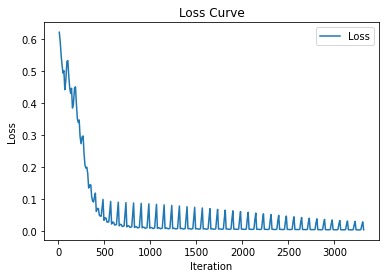

In [17]:
plt.plot(iter, losses, label='Loss')
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()

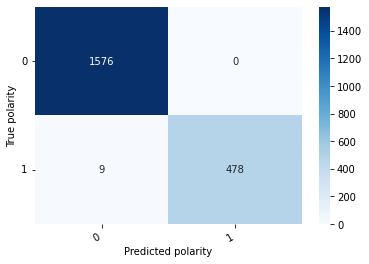

In [18]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True polarity')
  plt.xlabel('Predicted polarity');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=[0,1], columns=[0,1])
show_confusion_matrix(df_cm)


In [19]:
tp = 0
tn = 0
fp = 0
fn = 0
for i in range(len(y_test)):
  tn += ((y_pred[i] == 0) &  (y_test[i] == 0)).float()
  tp += ((y_pred[i] == 1) &  (y_test[i] == 1)).float()
  fn += ((y_pred[i] == 0) &  (y_test[i] == 1)).float()
  fp += ((y_pred[i] == 1) &  (y_test[i] == 0)).float()

print(tn, ' ', fn, ' ', fp, ' ', tp)

tensor(1576.)   tensor(9.)   tensor(0.)   tensor(478.)


In [20]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2* ((precision*recall)/(precision+recall))

In [21]:
print('Precision: ', precision.item(), 'Recall: ', recall.item(),  'F1_score: ', f1_score.item())

Precision:  1.0 Recall:  0.9815195202827454 F1_score:  0.9906736016273499


In [22]:
def table(l1, columns):
  plt.rcParams["figure.figsize"] = [10, 2]
  plt.rcParams["figure.autolayout"] = True
  
  fig, axs = plt.subplots(1, 1)
  data = np.column_stack(l1)
  axs.axis('tight')
  axs.axis('off')
  the_table = axs.table(cellText=data, colLabels=columns, loc='center', cellLoc = 'center')
  the_table.auto_set_font_size(False)
  the_table.set_fontsize(18)
  the_table.scale(1.5, 1.5)
  plt.show()